# RWE Analysis: Diabetes Readmission (UCI)

**Objective**: Analyze factors associated with 30-day readmission in diabetic patients.  
**Data**: Diabetes 130-US Hospitals (1999-2008) - UCI ID 296.  
**Method**: Multivariable Logistic Regression

In [1]:
# Setup - Install and import
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ucimlrepo", "-q"])
    from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

print("Dependencies loaded successfully.")

Dependencies loaded successfully.


In [2]:
# 1. Load Data directly from UCI
print("Fetching data from UCI (ID=296)... please wait.")
dataset = fetch_ucirepo(id=296)

# Combine features and targets
df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

print(f"\n✓ Data loaded: {len(df):,} encounters")
print(f"\nReadmission Distribution:")
print(df['readmitted'].value_counts(normalize=True).round(3))

Fetching data from UCI (ID=296)... please wait.



✓ Data loaded: 101,766 encounters

Readmission Distribution:
readmitted
NO     0.539
>30    0.349
<30    0.112
Name: proportion, dtype: float64


C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## 2. Preprocessing & Cohort Definition

In [3]:
# Define binary outcome: 1 if readmitted <30 days
df['outcome_30d'] = (df['readmitted'] == '<30').astype(int)

# Clean missing values encoded as '?'
df.replace('?', np.nan, inplace=True)

# Exclude invalid gender
df = df[df['gender'] != 'Unknown/Invalid']

print(f"Final cohort: {len(df):,} encounters")
print(f"Outcome rate (30-day readmission): {df['outcome_30d'].mean():.1%}")

Final cohort: 101,763 encounters
Outcome rate (30-day readmission): 11.2%


## 3. Cohort Characteristics (Table 1)

In [4]:
# Summary statistics
print("=" * 50)
print("COHORT CHARACTERISTICS")
print("=" * 50)

print(f"\nN = {len(df):,}")
print(f"\nAge Distribution:")
print(df['age'].value_counts().sort_index())

print(f"\nGender:")
print(df['gender'].value_counts())

print(f"\nTime in Hospital (mean): {df['time_in_hospital'].mean():.1f} days")
print(f"Num Medications (mean): {df['num_medications'].mean():.1f}")
print(f"Num Procedures (mean): {df['num_procedures'].mean():.1f}")

COHORT CHARACTERISTICS

N = 101,763

Age Distribution:
age
[0-10)        161
[10-20)       691
[20-30)      1657
[30-40)      3775
[40-50)      9685
[50-60)     17256
[60-70)     22482
[70-80)     26066
[80-90)     17197
[90-100)     2793
Name: count, dtype: int64

Gender:
gender
Female    54708
Male      47055
Name: count, dtype: int64

Time in Hospital (mean): 4.4 days
Num Medications (mean): 16.0
Num Procedures (mean): 1.3


## 4. Logistic Regression Model

In [5]:
# Prepare variables for modeling
df['time_hosp'] = df['time_in_hospital']
df['num_procs'] = df['num_procedures']
df['num_meds'] = df['num_medications']

# Logistic Regression
formula = "outcome_30d ~ C(age) + C(gender) + time_hosp + num_procs + num_meds"

print("Fitting model...")
model = smf.logit(formula=formula, data=df).fit(disp=0)
print("\n" + "=" * 60)
print("MODEL RESULTS")
print("=" * 60)
print(model.summary2().tables[1].to_string())

Fitting model...



MODEL RESULTS


                       Coef.  Std.Err.         z         P>|z|    [0.025    0.975]
Intercept          -4.130178  0.583004 -7.084310  1.397388e-12 -5.272843 -2.987512
C(age)[T.[10-20)]   1.129777  0.605206  1.866765  6.193440e-02 -0.056404  2.315958
C(age)[T.[20-30)]   2.088756  0.587123  3.557612  3.742414e-04  0.938016  3.239497
C(age)[T.[30-40)]   1.797823  0.585203  3.072138  2.125317e-03  0.650847  2.944799
C(age)[T.[40-50)]   1.717890  0.583890  2.942146  3.259466e-03  0.573486  2.862294
C(age)[T.[50-60)]   1.607530  0.583561  2.754693  5.874729e-03  0.463772  2.751288
C(age)[T.[60-70)]   1.749763  0.583391  2.999298  2.706026e-03  0.606338  2.893188
C(age)[T.[70-80)]   1.806845  0.583296  3.097644  1.950653e-03  0.663605  2.950085
C(age)[T.[80-90)]   1.825216  0.583425  3.128450  1.757307e-03  0.681724  2.968708
C(age)[T.[90-100)]  1.733077  0.586047  2.957233  3.104133e-03  0.584446  2.881708
C(gender)[T.Male]   0.014189  0.020191  0.702707  4.822382e-01 -0.025386  0.053763
time

## 5. Odds Ratios Table

In [6]:
# Calculate Odds Ratios with 95% CI
params = model.params
conf = model.conf_int()

results = pd.DataFrame({
    'Variable': params.index,
    'OR': np.exp(params).round(3),
    'CI_Lower': np.exp(conf[0]).round(3),
    'CI_Upper': np.exp(conf[1]).round(3),
    'P_value': model.pvalues.round(4)
})

# Remove intercept for display
results = results[results['Variable'] != 'Intercept'].reset_index(drop=True)

print("\n" + "=" * 70)
print("ODDS RATIOS FOR 30-DAY READMISSION")
print("=" * 70)
print(results.to_string(index=False))


ODDS RATIOS FOR 30-DAY READMISSION
          Variable    OR  CI_Lower  CI_Upper  P_value
 C(age)[T.[10-20)] 3.095     0.945    10.135   0.0619
 C(age)[T.[20-30)] 8.075     2.555    25.521   0.0004
 C(age)[T.[30-40)] 6.036     1.917    19.007   0.0021
 C(age)[T.[40-50)] 5.573     1.774    17.502   0.0033
 C(age)[T.[50-60)] 4.990     1.590    15.663   0.0059
 C(age)[T.[60-70)] 5.753     1.834    18.051   0.0027
 C(age)[T.[70-80)] 6.091     1.942    19.108   0.0020
 C(age)[T.[80-90)] 6.204     1.977    19.467   0.0018
C(age)[T.[90-100)] 5.658     1.794    17.845   0.0031
 C(gender)[T.Male] 1.014     0.975     1.055   0.4822
         time_hosp 1.033     1.026     1.041   0.0000
         num_procs 0.941     0.929     0.954   0.0000
          num_meds 1.014     1.011     1.017   0.0000


## 6. Forest Plot

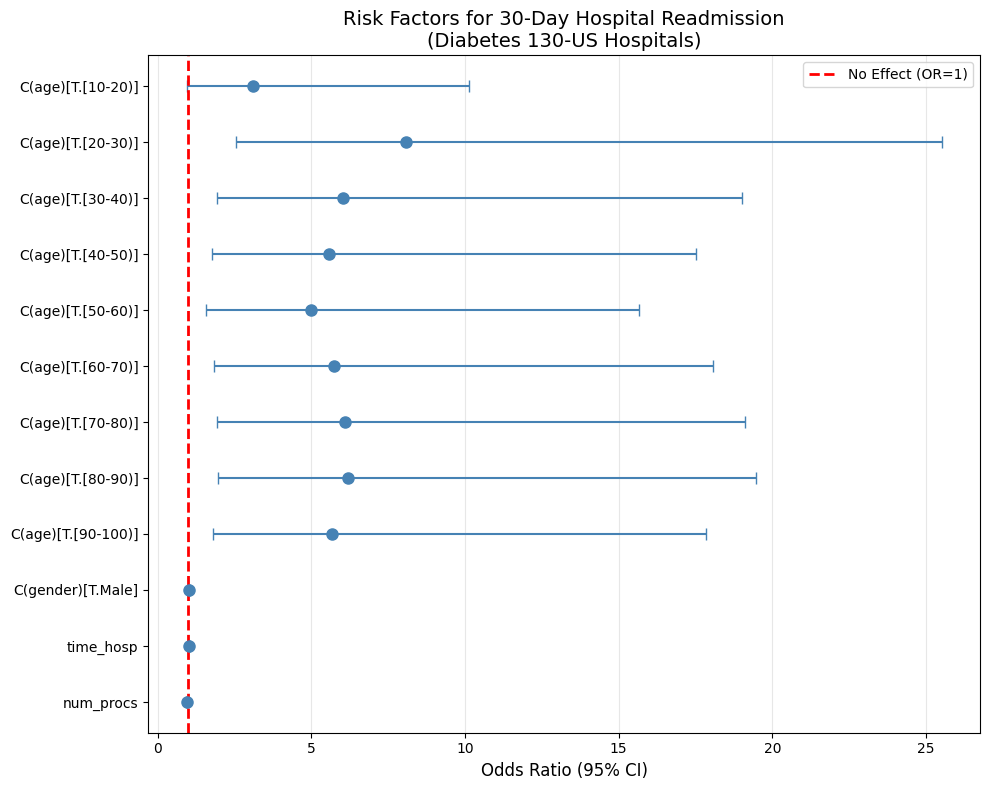

In [7]:
# Forest Plot
plot_data = results.head(12).iloc[::-1]  # Top 12 variables, reversed for plotting

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = range(len(plot_data))

ax.errorbar(
    plot_data['OR'], y_pos,
    xerr=[plot_data['OR'] - plot_data['CI_Lower'], plot_data['CI_Upper'] - plot_data['OR']],
    fmt='o', color='steelblue', capsize=4, markersize=8
)

ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='No Effect (OR=1)')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['Variable'])
ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12)
ax.set_title('Risk Factors for 30-Day Hospital Readmission\n(Diabetes 130-US Hospitals)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Findings Summary

In [8]:
print("\n" + "=" * 60)
print("KEY FINDINGS")
print("=" * 60)

# Identify significant results
sig_results = results[results['P_value'] < 0.05]

print(f"\nStatistically significant factors (p < 0.05): {len(sig_results)}")
print("\nTop risk factors (OR > 1):")
risk_factors = sig_results[sig_results['OR'] > 1].sort_values('OR', ascending=False)
for _, row in risk_factors.head(5).iterrows():
    print(f"  • {row['Variable']}: OR = {row['OR']:.2f} (p = {row['P_value']:.4f})")

print("\nProtective factors (OR < 1):")
protective = sig_results[sig_results['OR'] < 1].sort_values('OR')
for _, row in protective.head(3).iterrows():
    print(f"  • {row['Variable']}: OR = {row['OR']:.2f} (p = {row['P_value']:.4f})")


KEY FINDINGS

Statistically significant factors (p < 0.05): 11

Top risk factors (OR > 1):
  • C(age)[T.[20-30)]: OR = 8.07 (p = 0.0004)
  • C(age)[T.[80-90)]: OR = 6.20 (p = 0.0018)
  • C(age)[T.[70-80)]: OR = 6.09 (p = 0.0020)
  • C(age)[T.[30-40)]: OR = 6.04 (p = 0.0021)
  • C(age)[T.[60-70)]: OR = 5.75 (p = 0.0027)

Protective factors (OR < 1):
  • num_procs: OR = 0.94 (p = 0.0000)


---

## Limitations

- **Observational design**: Association ≠ Causation
- **Missing data**: Weight (97%), payer (40%) mostly missing
- **Historical**: Data from 1999-2008
- **Unmeasured confounders**: Disease severity, socioeconomic factors

---

**Data Source**: [UCI ML Repository - Diabetes 130-US Hospitals](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)  
**License**: CC BY 4.0